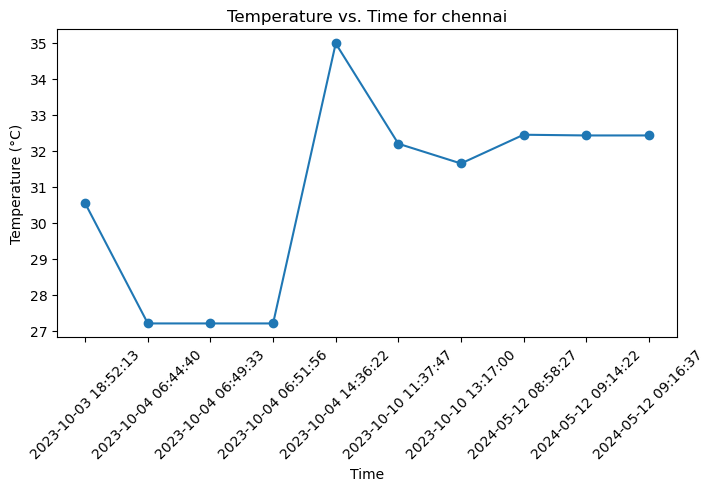

In [2]:
import tkinter as tk
import requests
import sqlite3
from datetime import datetime
import gettext
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Initialize the SQLite database
conn = sqlite3.connect("weather.db")
cursor = conn.cursor()

# Create a table to store weather data
cursor.execute("""
    CREATE TABLE IF NOT EXISTS weather (
    id INTEGER PRIMARY KEY,
    location TEXT,
    temperature REAL,
    condition TEXT,
    date_time DATETIME
);
""")
conn.commit()

# Function to insert weather data into the database
def insert_weather_data(location, temperature, condition, date_time):
    cursor.execute("INSERT INTO weather (location, temperature, condition, date_time) VALUES (?, ?, ?, ?)",
                   (location, temperature, condition, date_time))
    conn.commit()

# Function to get weather data from an online API
def get_weather_data(location):
    API_KEY = "10e0015c5570fa6f5fdb037cc8d78ae3"  # Replace with your API key
    base_url = "https://api.openweathermap.org/data/2.5/weather"
    params = {
        "q": location,
        "appid": API_KEY,
        "units": "metric"  # You can adjust units (e.g., metric, imperial)
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    return data

# Load translations based on the selected language
gettext.bindtextdomain("weather_app", "translations")
gettext.textdomain("weather_app")
_ = gettext.gettext

# Function to display weather information and create temperature vs. time graph
def display_weather():
    location = location_entry.get()
    weather_data = get_weather_data(location)

    if "name" in weather_data:
        temperature = weather_data["main"]["temp"]
        condition = weather_data["weather"][0]["description"]
        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        weather_label.config(text=_("Weather in {location}:").format(location=location))
        temperature_label.config(text=_("Temperature: {temperature}°C").format(temperature=temperature))
        condition_label.config(text=_("Condition: {condition}").format(condition=condition))
        date_time_label.config(text=_("Date and Time: {current_time}").format(current_time=current_time))

        insert_weather_data(location, temperature, condition, current_time)

        # Create a temperature vs. time graph
        create_temperature_graph(location)

    else:
        weather_label.config(text=_("Invalid location. Please try again."))
        temperature_label.config(text="")
        condition_label.config(text="")
        date_time_label.config(text="")

# Function to create a temperature vs. time graph
def create_temperature_graph(location):
    cursor.execute("SELECT date_time, temperature FROM weather WHERE location=?", (location,))
    rows = cursor.fetchall()

    if len(rows) > 0:
        dates = [row[0] for row in rows]
        temperatures = [row[1] for row in rows]

        plt.figure(figsize=(8, 4))
        plt.plot(dates, temperatures, marker='o', linestyle='-')
        plt.title(_("Temperature vs. Time for {location}").format(location=location))
        plt.xlabel(_("Time"))
        plt.ylabel(_("Temperature (°C)"))

        # Customize x-axis labels to avoid overlap
        plt.xticks(rotation=45)  # Rotate labels by 45 degrees
        
        # Alternatively, specify intervals for labels
        # plt.xticks(dates[::2], rotation=45)  # Display every second label

        # Create a Tkinter canvas to display the graph
        canvas = FigureCanvasTkAgg(plt.gcf(), master=root)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.grid(row=6, column=0, columnspan=3)


# Create the main window
root = tk.Tk()
root.title(_("Weather App"))  # Title in the selected language

# Create labels, entry field, and button for user input
location_label = tk.Label(root, text=_("Enter Location:"))
location_entry = tk.Entry(root)
get_weather_button = tk.Button(root, text=_("Get Weather"), command=display_weather)

# Create labels to display weather information
weather_label = tk.Label(root, text="")
temperature_label = tk.Label(root, text="")
condition_label = tk.Label(root, text="")
date_time_label = tk.Label(root, text="")

# Grid layout for widgets
location_label.grid(row=0, column=0)
location_entry.grid(row=0, column=1)
get_weather_button.grid(row=0, column=2)
weather_label.grid(row=1, column=0, columnspan=3)
temperature_label.grid(row=2, column=0, columnspan=3)
condition_label.grid(row=3, column=0, columnspan=3)
date_time_label.grid(row=4, column=0, columnspan=3)

# Create a language selection menu
language_label = tk.Label(root, text=_("Select Language:"))
language_label.grid(row=5, column=0)
languages = [_("English"), _("French")]  # Add more languages as needed
language_var = tk.StringVar(value=_("English"))
language_menu = tk.OptionMenu(root, language_var, *languages)
language_menu.grid(row=5, column=1)

# Start the Tkinter main loop
root.mainloop()

# Close the database connection when the application is closed
conn.close()
